# ECON 323 Final Project

##### ***Analysis of the lifestyle and cost of living of cities around the world*** #####

### Background ###

For this project, I will analyze and merge two datasets: healthy lifestyle metrics of the top 44 cities in the world (https://www.kaggle.com/datasets/prasertk/healthy-lifestyle-cities-report-2021) and the cost of living index by cities (https://www.kaggle.com/datasets/debdutta/cost-of-living-index-by-country). My goal is to see if both datasets are able to explain each other and whether variables from one dataset can predict variables in another dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
%matplotlib inline

### Datasets Cleaning, Wrangling and Merging ###

In [2]:
healthy_lifestyle_city = pd.read_csv("healthy_lifestyle_city_2021.csv")
healthy_lifestyle_city['Obesity levels(Country)'] = healthy_lifestyle_city['Obesity levels(Country)'].str.strip("%")
healthy_lifestyle_city['Cost of a bottle of water(City)'] = healthy_lifestyle_city['Cost of a bottle of water(City)'].str.strip("£")
healthy_lifestyle_city['Cost of a monthly gym membership(City)'] = healthy_lifestyle_city['Cost of a monthly gym membership(City)'].str.strip("£")
cols = ['Sunshine hours(City)','Cost of a bottle of water(City)', 'Obesity levels(Country)', 'Pollution(Index score) (City)', 'Annual avg. hours worked', 'Cost of a monthly gym membership(City)']

healthy_lifestyle_city[cols] = healthy_lifestyle_city[cols].apply(pd.to_numeric, errors='coerce', axis=1)

healthy_lifestyle_city['Sunshine hours(City)'] = healthy_lifestyle_city['Sunshine hours(City)'].astype('Int64')
healthy_lifestyle_city['Annual avg. hours worked'] = healthy_lifestyle_city['Annual avg. hours worked'].astype('Int64')
healthy_lifestyle_city = healthy_lifestyle_city.rename(columns={"Annual avg. hours worked":"Annual average hours worked"})
healthy_lifestyle_city = healthy_lifestyle_city[["City", "Rank", "Sunshine hours(City)", "Cost of a bottle of water(City)", "Pollution(Index score) (City)", "Annual average hours worked",
                                                 "Outdoor activities(City)", "Number of take out places(City)", "Cost of a monthly gym membership(City)", 
                                                 "Obesity levels(Country)", "Life expectancy(years) (Country)", "Happiness levels(Country)"]]
healthy_lifestyle_city.head(6)

,City,Rank,Sunshine hours(City),Cost of a bottle of water(City),Pollution(Index score) (City),Annual average hours worked,Outdoor activities(City),Number of take out places(City),Cost of a monthly gym membership(City),Obesity levels(Country),Life expectancy(years) (Country),Happiness levels(Country)
0,Amsterdam,1,1858,1.92,30.93,1434,422,1048,34.90,20.4,81.2,7.44
1,Sydney,2,2636,1.48,26.86,1712,406,1103,41.66,29.0,82.1,7.22
2,Vienna,3,1884,1.94,17.33,1501,132,1008,25.74,20.1,81.0,7.29
3,Stockholm,4,1821,1.72,19.63,1452,129,598,37.31,20.6,81.8,7.35
4,Copenhagen,5,1630,2.19,21.24,1380,154,523,32.53,19.7,79.8,7.64
5,Helsinki,6,1662,1.60,13.08,1540,113,309,35.23,22.2,80.4,7.80


#### Healthy lifestyle Attributes ####

- **Sunshine hours(City)**
- **Cost of a bottle of water(City)** - in Euros (£)
- **Obesity levels(Country)** - percentage (%)
- **Life expectancy(years)(Country)**
- **Pollution(Index score)(City)** - out of 100
- **Annual avg. hours worked**
- **Happiness levels(Country)** - out of 10
- **Outdoor activities(City)**
- **Number of take out places(City)**
- **Cost of a monthly gym membership(City)** - in Euros (£)

In [3]:
cost_of_living_index = pd.read_csv("Cost_of_living_index.csv")
cost_of_living_index[['City', 'Country']] = cost_of_living_index['City'].str.split(',', 1, expand=True)
cost_of_living_index = cost_of_living_index[['City','Country','Cost of Living Index',
                                             'Rent Index','Cost of Living Plus Rent Index',
                                             'Groceries Index','Restaurant Price Index','Local Purchasing Power Index']]

After cleaning and inspecting both data sets, I will now check if the cities in the healthy lifestyle city dataset exist in the cost of living index dataset. However, 'Vancouver' and 'London' are listed twice in the cost of living index dataset which are referring to the cities in both Canada and the United States and Canada and the UK, respectively. However, the healthy lifestyle dataset is referring to Vancouver, BC, Canada, and London, UK not Vancouver, WA, United States nor London, Ontario, Canada. So, I will change the naming in the cost of living index dataset before I proceed further. In addition, I will change the formatting of both Washington, DC, and Tel Aviv in the cost of living index dataset to match the formatting in the healthy lifestyle dataset. And finally, I will strip the states off of "United States" to ensure successful grouping by country later on.

In [4]:
cost_of_living_index.loc[277, 'City'] = "Vancouver, WA"
cost_of_living_index.loc[17, 'City'] = "Washington, D.C."
cost_of_living_index.loc[51, 'City'] = "Tel Aviv"
cost_of_living_index.loc[290, 'City'] = "London, ON"
cost_of_living_index["String Present"] = np.where(cost_of_living_index["Country"].str.contains("United States"), "Yes", "No")
cost_of_living_index.loc[cost_of_living_index["String Present"] == "Yes", 'Country'] = "United States"
cost_of_living_index = cost_of_living_index.drop('String Present', axis=1)

In [5]:
cost_of_living_index.head(6)

,City,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,Hamilton,Bermuda,137.56,103.03,121.21,126.56,151.77,114.19
1,Zurich,Switzerland,128.65,62.62,97.39,127.35,127.14,142.39
2,Basel,Switzerland,126.89,46.14,88.66,120.44,129.10,141.48
3,Lausanne,Switzerland,119.62,50.35,86.83,116.35,122.83,132.58
4,Bern,Switzerland,118.42,39.22,80.93,114.54,114.86,115.48
5,Geneva,Switzerland,118.33,69.16,95.06,112.08,119.78,133.47


Cost of Living Index (excluding rent) is a relative indicator of consumer goods prices, including groceries, restaurants, transportation and utilities and doesn't include accommodation expenses such as rent or mortgage. If a city has a Cost of Living Index of 120, it means it is 20% more expensive than New York City (NYC).

#### Cost of Living Index Attributes ####
- **Rent Index**: an estimation of prices of renting apartments in the city compared to NYC 
- **Groceries Index**: estimation of grocery prices in the city compared to NYC
- **Restaurants Index**: comparison of prices of meals and drinks in restaurants and bars compared to NYC
- **Cost of Living Plus Rent Index**: an estimation of consumer goods prices including rent comparing to NYC
- **Local Purchasing Power**: purchasing power in buying goods and services in a given city for the average wage in that city relative to NYC

In [6]:
df = cost_of_living_index.loc[cost_of_living_index['City'].isin(healthy_lifestyle_city['City'])]
df.shape[0]

43

That means there is cost of living index data for 43 out of the 44 cities from the healthy lifestyle city data. The only city whose cost of living index does not exist is Fukuoka, Japan. From now on, I will continue using the merged dataset with the exclusion of Fukuoka. In addition, I will rename the Rank column to specify that it is the healthy lifestyle rank, not the cost of index rank, that is being displayed in the merged dataset. 

In [7]:
merge_by_city = healthy_lifestyle_city.merge(cost_of_living_index, on='City', how='inner')
merge_by_city = merge_by_city.rename(columns={"Rank":"Rank(Healthy lifestyle)"})
merge_by_city.head(6)

,City,Rank(Healthy lifestyle),Sunshine hours(City),Cost of a bottle of water(City),Pollution(Index score) (City),Annual average hours worked,Outdoor activities(City),Number of take out places(City),Cost of a monthly gym membership(City),Obesity levels(Country),Life expectancy(years) (Country),Happiness levels(Country),Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,Amsterdam,1,1858,1.92,30.93,1434,422,1048,34.90,20.4,81.2,7.44,Netherlands,82.14,54.65,69.13,62.35,87.71,98.88
1,Sydney,2,2636,1.48,26.86,1712,406,1103,41.66,29.0,82.1,7.22,Australia,79.93,62.58,71.72,68.63,69.34,128.25
2,Vienna,3,1884,1.94,17.33,1501,132,1008,25.74,20.1,81.0,7.29,Austria,70.86,32.48,52.70,63.61,67.94,104.56
3,Stockholm,4,1821,1.72,19.63,1452,129,598,37.31,20.6,81.8,7.35,Sweden,77.23,40.18,59.69,64.74,85.51,115.83
4,Copenhagen,5,1630,2.19,21.24,1380,154,523,32.53,19.7,79.8,7.64,Denmark,87.91,47.84,68.94,64.59,113.18,114.05
5,Helsinki,6,1662,1.60,13.08,1540,113,309,35.23,22.2,80.4,7.80,Finland,80.60,35.69,59.34,61.31,94.99,108.83


### Data Visualization & Analysis ###

In [8]:
chart1 = alt.Chart(merge_by_city, width=500, height=300).mark_bar().encode(
    alt.X("City", type='ordinal', sort="-y"),
    alt.Y(alt.repeat(), type='quantitative'),
    alt.Color('City', legend=None, scale=alt.Scale(scheme='tableau20')))

text = chart1.mark_text(baseline='middle',
    dx=20,
    angle=280,
    color='black',
).encode(
    text=alt.Text('Rank(Healthy lifestyle):Q'))

(chart1 + text).repeat(['Sunshine hours(City)','Cost of a bottle of water(City)', 'Pollution(Index score) (City)', 'Annual average hours worked', 
            'Outdoor activities(City)','Number of take out places(City)', 'Cost of a monthly gym membership(City)', 
            'Cost of Living Index', 'Rent Index', 'Cost of Living Plus Rent Index', 'Groceries Index', 
            'Restaurant Price Index','Local Purchasing Power Index'])

alt.RepeatChart(...)

From the above graphs, we can see that Zurich, Switzerland (Rank 37 in healthy lifestyle), is on a streak, scoring first place in the cost of a bottle of water and cost of monthly gym membership from the healthy lifestyle dataset and cost of living index, grocery index, restaurant price index and local purchasing power index from the cost of living index dataset. It is nice to see how both datasets explain each other! Now, I will do some country analysis/visualizations.

In [9]:
selected = merge_by_city[['Country','Obesity levels(Country)','Happiness levels(Country)', 'Life expectancy(years) (Country)']].drop_duplicates()
group_by_country = cost_of_living_index.groupby("Country").agg(["mean"])
merge_by_country = group_by_country.merge(selected, on='Country', how='inner')
merge_by_country.columns = ['Country','Avg cost of living index', 'Avg rent index','Avg cost of living plus rent index','Avg Groceries Index','Avg restaurant price index','Avg local purchasing power index','Obesity levels(Country)','Happiness levels(Country)','Life expectancy(years) (Country)']
merge_by_country.head(6)

/var/folders/4m/jw1qp7pd3cx919n025z0prfr0000gn/T/ipykernel_84686/2339514992.py:2: FutureWarning: ['City'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  group_by_country = cost_of_living_index.groupby("Country").agg(["mean"])
/var/folders/4m/jw1qp7pd3cx919n025z0prfr0000gn/T/ipykernel_84686/2339514992.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  merge_by_country = group_by_country.merge(selected, on='Country', how='inner')


,Country,Avg cost of living index,Avg rent index,Avg cost of living plus rent index,Avg Groceries Index,Avg restaurant price index,Avg local purchasing power index,Obesity levels(Country),Happiness levels(Country),Life expectancy(years) (Country)
0,Argentina,38.570000,11.750000,25.870000,29.660000,37.470000,59.760000,28.3,5.97,75.9
1,Australia,72.033000,38.904000,56.352000,64.478000,72.537000,133.370000,29.0,7.22,82.1
2,Austria,74.732500,28.260000,52.737500,66.197500,70.272500,99.942500,20.1,7.29,81.0
3,Belgium,75.105000,27.807500,52.717500,60.510000,85.560000,97.307500,22.1,6.86,80.4
4,Brazil,41.895556,12.134444,27.806667,29.653333,36.796667,42.804444,22.1,6.37,73.9
5,Canada,66.046552,29.350000,48.675517,60.566207,63.563448,117.110690,29.4,7.23,81.7


In [10]:
chart2 = alt.Chart(merge_by_country, width=500, height=300).mark_bar().encode(
    alt.X("Country", type='ordinal', sort="-y"),
    alt.Y(alt.repeat("column"), type='quantitative'),
    alt.Color('Country', legend=None, scale=alt.Scale(scheme='tableau20'))).repeat(
    column=['Avg cost of living index', 'Avg rent index','Avg cost of living plus rent index',
            'Avg Groceries Index','Avg restaurant price index','Avg local purchasing power index',
            'Obesity levels(Country)','Happiness levels(Country)','Life expectancy(years) (Country)'])
chart2 

alt.RepeatChart(...)

When grouped and graphed by country, Switzerland (the average of Zurich, Basel, Lausanne, Bern, Geneva and Lugano) scores high on average living index, average cost of living plus rent index, average grocery index and average restaurant price index which overlapped greatly to the variables that Zurich alone scored high on. Again, looks like the data as whole is consistent and flows nicely. Now, I will create a correlation graph for the variables in both merged by city and merged by country datasets , but first, I will scale the datasets since the units are different.

#### City Variables ####

In [11]:
merged_by_city_columns = merge_by_city.drop(["City", "Rank(Healthy lifestyle)", "Country"], axis=1).columns
merged_by_city_columns
scaled_data = merge_by_city.drop(["City", "Rank(Healthy lifestyle)", "Country"], axis=1)
scaler = StandardScaler() 
scaled_data = scaler.fit_transform(scaled_data)
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = merged_by_city_columns
scaled_data['City']= merge_by_city['City']
scaled_data.head(6)

,Sunshine hours(City),Cost of a bottle of water(City),Pollution(Index score) (City),Annual average hours worked,Outdoor activities(City),Number of take out places(City),Cost of a monthly gym membership(City),Obesity levels(Country),Life expectancy(years) (Country),Happiness levels(Country),Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,City
0,-0.668582,1.029839,-0.934806,-1.335616,1.641950,-0.301161,-0.348320,-0.196905,0.598743,1.004555,0.570605,0.508318,0.574811,0.028659,0.771134,0.156811,Amsterdam
1,0.717007,0.415378,-1.123227,0.212682,1.513081,-0.261358,0.107944,0.678282,0.770256,0.781740,0.470199,0.853922,0.697465,0.300592,0.091267,1.142470,Sydney
2,-0.622277,1.057769,-1.564419,-0.962465,-0.693792,-0.330110,-0.966571,-0.227435,0.560629,0.852636,0.058122,-0.457894,-0.203259,0.083219,0.039454,0.347432,Vienna
3,-0.734477,0.750539,-1.457941,-1.235367,-0.717955,-0.626828,-0.185657,-0.176552,0.713085,0.913404,0.347530,-0.122313,0.127764,0.132150,0.689713,0.725654,Stockholm
4,-1.074641,1.406895,-1.383406,-1.636365,-0.516598,-0.681105,-0.508282,-0.268141,0.331946,1.207115,0.832753,0.211524,0.565814,0.125654,1.713769,0.665917,Copenhagen
5,-1.017650,0.582958,-1.761174,-0.745258,-0.846824,-0.835978,-0.326046,-0.013727,0.446288,1.369163,0.500639,-0.317996,0.111189,-0.016374,1.040564,0.490734,Helsinki


In [12]:
scatter = alt.Chart(scaled_data, width=150, height=150).mark_circle().encode(
    alt.X(alt.repeat("row"), type='quantitative'),
    alt.Y(alt.repeat("column"), type='quantitative'),
    alt.Color('City', legend=None, scale=alt.Scale(scheme='tableau20'))).repeat(
    row=['Sunshine hours(City)','Cost of a bottle of water(City)', 'Pollution(Index score) (City)', 'Annual average hours worked', 
            'Outdoor activities(City)','Number of take out places(City)', 'Cost of a monthly gym membership(City)','Cost of Living Index', 'Rent Index', 'Cost of Living Plus Rent Index', 'Groceries Index', 
            'Restaurant Price Index','Local Purchasing Power Index'],
    column=['Sunshine hours(City)','Cost of a bottle of water(City)', 'Pollution(Index score) (City)', 'Annual average hours worked', 
            'Outdoor activities(City)','Number of take out places(City)', 'Cost of a monthly gym membership(City)','Cost of Living Index', 'Rent Index', 'Cost of Living Plus Rent Index', 'Groceries Index', 
            'Restaurant Price Index','Local Purchasing Power Index'])
scatter

alt.RepeatChart(...)

### Variables with positive correlation: ###  
- Cost of a bottle of water(City) & Restaurant Price Index
- Cost of a bottle of water(City) & Rent Index
- Cost of a bottle of water(City) & Cost of Living Plus Rent Index
- Cost of a bottle of water(City) & Local Purchasing Power Index
- Cost of a bottle of water(City) & Cost of Living Index
- Cost of a bottle of water(City) & Groceries Index
- Cost of a monthly gym membership(City) & Cost of Living Index
- Cost of a monthly gym membership(City) & Rent Index
- Cost of a monthly gym membership(City) & Groceries Index
- Cost of a monthly gym membership(City) & Restaurant Price Index
- Cost of a monthly gym membership(City) & Cost of Living Plus Rent Index
- Cost of a monthly gym membership(City) & Local Purchasing Power Index

### Variables with negative correlation: ### 
- Pollution Index(City) & Cost of Living Index
- Pollution Index(City) & Restaurant Price Index
- Pollution Index(City) & Local Purchasing Power Index
- Pollution Index(City) & Rent Index
- Pollution Index(City) & Cost of Living Plus Rent Index

Even though the variables within the cost of living index dataset have a positive correlation, I will only choose the variables from each dataset that have a correlation since I am trying to figure out if the datasets correlate or can "explain" each other.

#### Country Variables ####

In [13]:
merged_by_country_columns = merge_by_country.drop(["Country"], axis=1).columns
merged_by_country_columns
scaled_data2 = merge_by_country.drop(["Country"], axis=1)
scaler = StandardScaler() 
scaled_data2 = scaler.fit_transform(scaled_data2)
scaled_data2 = pd.DataFrame(scaled_data2)
scaled_data2.columns = merged_by_country_columns
scaled_data2['Country']= merge_by_city['Country']

scatter2 = alt.Chart(scaled_data2, width=150, height=150).mark_circle().encode(
    alt.X(alt.repeat("row"), type='quantitative'),
    alt.Y(alt.repeat("column"), type='quantitative'),
    alt.Color('Country', legend=None, scale=alt.Scale(scheme='tableau20'))).repeat(
    row=['Avg cost of living index', 'Avg rent index','Avg cost of living plus rent index',
            'Avg Groceries Index','Avg restaurant price index','Avg local purchasing power index',
            'Obesity levels(Country)','Happiness levels(Country)','Life expectancy(years) (Country)'],
    column=['Avg cost of living index', 'Avg rent index','Avg cost of living plus rent index',
            'Avg Groceries Index','Avg restaurant price index','Avg local purchasing power index',
            'Obesity levels(Country)','Happiness levels(Country)','Life expectancy(years) (Country)'])
scatter2

alt.RepeatChart(...)

### Variables with positive correlation: ###  
- Happiness levels(Country) & Restaurant Price Index
- Happiness levels(Country) & Rent Index
- Happiness levels(Country) & Cost of Living Plus Rent Index
- Happiness levels(Country) & Local Purchasing Power Index
- Happiness levels(Country) & Cost of Living Index
- Happiness levels(Country) & Groceries Index
- Life expectancy(years) (Country) & Cost of Living Index
- Life expectancy(years) (Country) & Rent Index
- Life expectancy(years) (Country)) & Groceries Index
- Life expectancy(years) (Country) & Restaurant Price Index
- Life expectancy(years) (Country) & Cost of Living Plus Rent Index
- Life expectancy(years) (Country) & Local Purchasing Power Index

Unfortunately, there is no correlation between the third variable - Obesity levels(Country) - and the cost of living index variables

### Machine Learning - Multiple Linear Regression ###

Can the three healthy life style city variables  predict the cost of living index variable for each city? Let's find out!

In [14]:
np.random.seed(1234) #to avoid the numbers from changing every time code is run

copy = scaled_data.copy()
copy = scaled_data.fillna(0)

X1 = np.array(copy[['Cost of a bottle of water(City)', 'Pollution(Index score) (City)', 'Cost of a monthly gym membership(City)']])
Y1 = np.array(copy['Cost of Living Index'])

for i in range(1000): #repeating 1000 times results in a lower RMSE
    X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.33, shuffle= True)
    linereg = LinearRegression()
    linereg.fit(X_train, y_train)
y_pred = linereg.predict(X_test)
print('Mean Absolute Error (city variables):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (city variables):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (city variables):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error (city variables): 0.22620474343391664
Mean Squared Error (city variables): 0.06955269993256147
Root Mean Squared Error (city variables): 0.2637284587081217


/Users/sarahabdelazim/opt/miniconda3/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

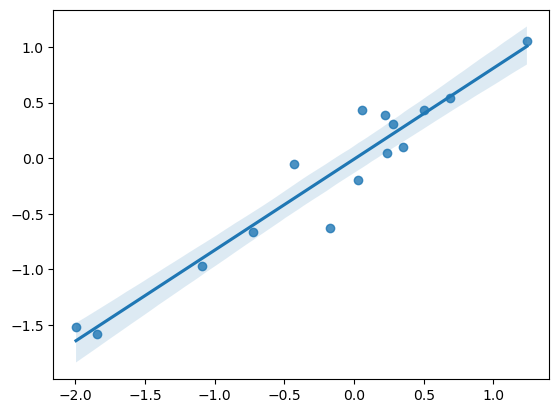

In [15]:
sns.regplot(y_test, y_pred)

Can the two healthy life style country variables  predict the average cost of living index variable by country? Let's find out!

In [16]:
np.random.seed(1234) #to avoid the numbers from changing every time code is run

copy2 = scaled_data2.copy()
copy2 = scaled_data2.fillna(0)

X2 = np.array(copy2[['Happiness levels(Country)','Life expectancy(years) (Country)']])
Y2 = np.array(copy2['Avg cost of living index'])

for i in range(1000): ##repeating 1000 times results in a lower RMSE
    X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.33, shuffle= True)
    linereg = LinearRegression()
    linereg.fit(X_train, y_train)
y_pred = linereg.predict(X_test)
print('Mean Absolute Error (country variables):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (country variables):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (country variables):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error (country variables): 0.7019529314073634
Mean Squared Error (country variables): 1.0643764774216549
Root Mean Squared Error (country variables): 1.031686230121181


/Users/sarahabdelazim/opt/miniconda3/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

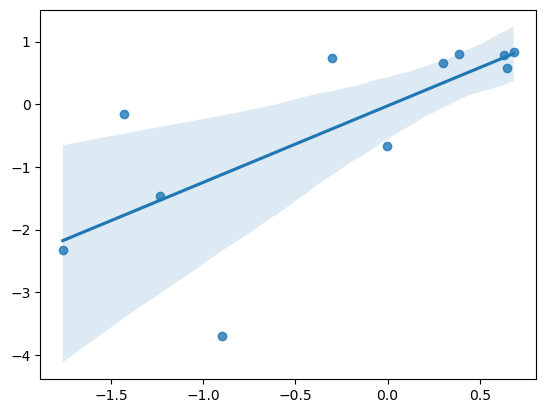

In [17]:
sns.regplot(y_test, y_pred)

### Conclusion ###

The three city variables are more correlated to and are better able to predict the cost of living index variable than the two country variables are to the average cost of living index since the MSE of city varibales is much smaller than the MSE of country variables. In the future, I aim to produce a multi-output regression model where I can predict multiple variables from the cost of living index dataset instead of just one.